<a href="https://colab.research.google.com/github/nathankim7/colab-notebooks/blob/master/Neural_Machine_Translation_WMT_'14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 450kB 37.8MB/s 
     |████████████████████████████████| 3.8MB 34.0MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.6.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goog

In [3]:
import spacy
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, Sequence, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
spacy.cli.download("fr_core_news_sm")

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [4]:
tf.__version__

'2.0.0'

In [5]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [0]:
nlp = { 'en': spacy.load("en_core_web_sm", disable=['parser', 'ner', 'tagger', 'textcat']),
  'fr': spacy.load("fr_core_news_sm", disable=['parser', 'ner', 'tagger', 'textcat']) }
path = { 'en': './gdrive/My Drive/translation data/europarl-v7.fr-en.en',
       'fr': './gdrive/My Drive/translation data/europarl-v7.fr-en.fr'}

class Language:
  def __init__(self, name):
    self.name = name
    self.data = []
    self.tokenizer = Tokenizer(filters='')
  def load(self):
    with open(path[self.name], 'r') as f:
      text = f.read()

    rawData = text.split('\n')[:50000]
    rawData = [['<start>'] + [t.text for t in nlp[self.name](line)] + ['<end>'] for line in rawData]
    return rawData
  def create_dataset(self, rawData, num_examples, max_len):
    self.data = [line for line in rawData if len(line) <= max_len]
    self.data = self.data[:num_examples]
    self.tokenizer.fit_on_texts(self.data)
    self.data = self.tokenizer.texts_to_sequences(self.data)
    self.data = pad_sequences(self.data, padding='post')

In [7]:
num_examples = 16000
max_len = 50

"""EN = Language('en')
rawEN = EN.load()
FR = Language('fr')
rawFR = FR.load()

outfile=open('./gdrive/My Drive/translation data/preprocessed/en_processed.pkl', 'wb')
pickle.dump(rawEN, outfile)
outfile.close()
outfile = open('./gdrive/My Drive/translation data/preprocessed/fr_processed.pkl', 'wb')
pickle.dump(rawFR, outfile)
outfile.close()"""

"EN = Language('en')\nrawEN = EN.load()\nFR = Language('fr')\nrawFR = FR.load()\n\noutfile=open('./gdrive/My Drive/translation data/preprocessed/en_processed.pkl', 'wb')\npickle.dump(rawEN, outfile)\noutfile.close()\noutfile = open('./gdrive/My Drive/translation data/preprocessed/fr_processed.pkl', 'wb')\npickle.dump(rawFR, outfile)\noutfile.close()"

In [0]:
infile = open('./gdrive/My Drive/translation/preprocessed/en50.pkl', 'rb')
EN = pickle.load(infile)
infile.close()
infile = open('./gdrive/My Drive/translation/preprocessed/fr50.pkl', 'rb')
FR = pickle.load(infile)
infile.close()

In [0]:
len_sentEN = len(EN.data[0])
len_sentFR = len(FR.data[0])
num_wordsEN = len(EN.tokenizer.word_index)
num_wordsFR = len(FR.tokenizer.word_index)

trainEN, valEN, trainFR, valFR = train_test_split(EN.data, FR.data, test_size=0.2)
trainEN = np.array(trainEN, dtype='int32')
valEN = np.array(valEN, dtype='int32')
trainFR = np.array(trainFR, dtype='int32')
valFR = np.array(valFR, dtype='int32')

In [10]:
trainEN.shape

(33600, 50)

In [0]:
class DataGenerator(Sequence):
  def __init__(self, inp, targ, input_dim=(1,1,1), output_dim=(1,1,1), 
               batch_size=64, n_classes=10, shuffle=True):
    self.inp = inp
    self.targ = targ
    self.batch_size = batch_size
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()
  def __len__(self):
    return len(self.inp) // self.batch_size
  def on_epoch_end(self):
    self.indices = np.arange(len(self.inp))

    if self.shuffle:
      np.random.shuffle(self.indices)
  def __data_generation(self, indices):
    enc_inp = np.zeros((self.batch_size, *self.input_dim), dtype='int32')
    dec_inp = np.zeros((self.batch_size, *self.output_dim), dtype='int32')
    dec_out = np.zeros((self.batch_size, *self.output_dim, self.n_classes), dtype='int32')

    for ind, i in enumerate(indices):
      enc_inp[ind,] = self.inp[i]
      dec_inp[ind,] = self.targ[i]
      dec_out[ind,:-1] = to_categorical(self.targ[i, 1:], self.n_classes)

    return [enc_inp, dec_inp], dec_out
  def __getitem__(self, index):
    indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

    return self.__data_generation(indices)

In [0]:
BATCH_SIZE = 128
steps_per_epoch = len(trainEN)
embedding_dim = 256
hid_units = 256

In [0]:
training_generator = DataGenerator(trainEN, trainFR, input_dim=(len_sentEN,), 
                                   output_dim=(len_sentFR,), batch_size=BATCH_SIZE,
                                   n_classes=num_wordsFR + 1)
validation_generator = DataGenerator(valEN, valFR, input_dim=(len_sentEN,), 
                                     output_dim=(len_sentFR,), batch_size=BATCH_SIZE,
                                     n_classes=num_wordsFR + 1)

In [0]:
def define_models(embedding_dim, hid_units):
  encoder_inputs = Input(shape=(None,))
  embedded_encoder_inputs = Embedding(num_wordsEN + 1, embedding_dim)(encoder_inputs)
  encoder_gru = GRU(hid_units, return_state=True)
  encoder_outputs, encoder_state = encoder_gru(embedded_encoder_inputs)

  decoder_inputs = Input(shape=(None,))
  embedded_decoder_inputs = Embedding(num_wordsFR + 1, embedding_dim)(decoder_inputs)
  decoder_gru = GRU(hid_units, return_sequences=True, return_state=True)
  decoder_outputs, _ = decoder_gru(embedded_decoder_inputs, initial_state=encoder_state)
  decoder_dense = Dense(num_wordsFR + 1, activation='softmax')
  decoder_outputs = decoder_dense(decoder_outputs)

  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  encoder_model = Model(encoder_inputs, encoder_state)

  decoder_state_input = Input(shape=(hid_units))
  decoder_outputs, decoder_state = decoder_gru(embedded_decoder_inputs, initial_state=decoder_state_input)
  decoder_outputs = decoder_dense(decoder_outputs)
  decoder_model = Model([decoder_inputs, decoder_state_input], [decoder_outputs, decoder_state])
  return model, encoder_model, decoder_model

In [0]:
train_model, inf_enc, inf_dec = define_models(embedding_dim, hid_units)

In [0]:
train_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    4806144     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    6607104     input_2[0][0]                    
______________________________________________________________________________________________

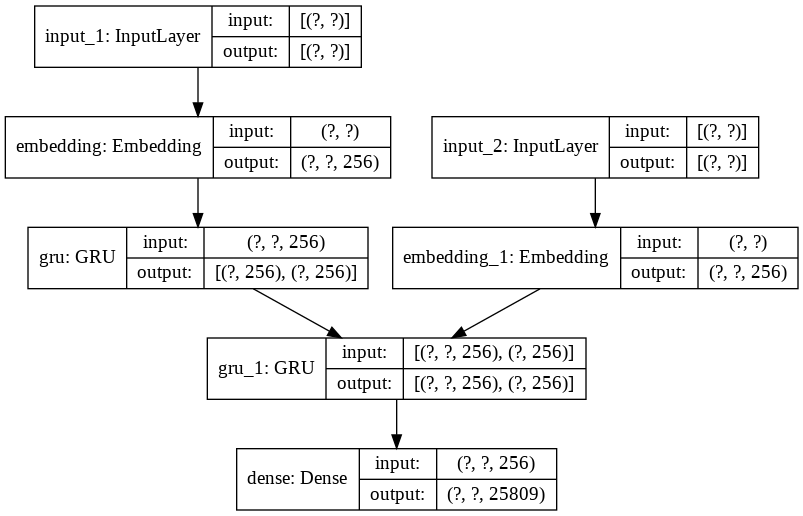

In [17]:
train_model.summary()
plot_model(train_model, 'model.png', show_shapes=True)

In [18]:
train_model.load_weights('./gdrive/My Drive/translation/saved models/4th.hdf5')

ValueError: ignored

In [67]:
early_stop = tf.keras.callbacks.EarlyStopping('val_loss', patience=4)

history = train_model.fit_generator(generator=training_generator,
                                    validation_data=validation_generator,
                                    validation_steps=len(valEN) // BATCH_SIZE,
                                    use_multiprocessing=True,
                                    workers=4,
                                    epochs=5,
                                    callbacks=[early_stop])

train_model.save_weights('./12th.hdf5')
train_model.save_weights('./gdrive/My Drive/translation/saved models/12th.hdf5')

Epoch 1/5
 20/262 [=>............................] - ETA: 9:47 - loss: 8.0845 - accuracy: 0.4574

Process Keras_worker_ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-10:
Process Keras_worker_ForkPoolWorker-12:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
   

Epoch 1/5

  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: ignored

Process Keras_worker_ForkPoolWorker-11:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 341, in put
    obj = _ForkingPickler.dumps(obj)
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)


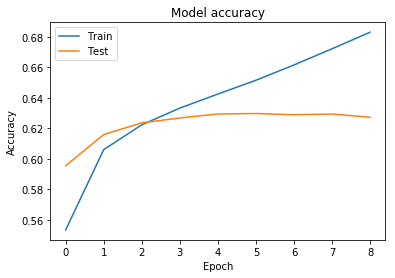

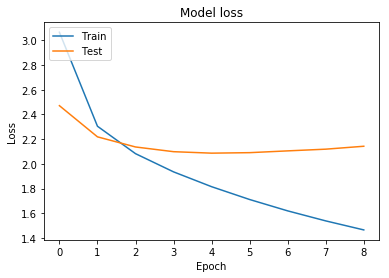

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig('acc.svg')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig('loss.svg')

In [0]:
def evaluate(input_sequence):
  state = inf_enc.predict(input_sequence)
  target_input = np.expand_dims([FR.tokenizer.word_index['<start>']], 0)
  result = ''

  for t in range(len_sentFR):
    pred, state = inf_dec.predict([target_input, state])
    predicted_id = np.argmax(pred[0, 0, :])
    predicted_word = FR.tokenizer.index_word[predicted_id]

    if (predicted_word == '<end>'):
      return result

    result += predicted_word + ' '
    target_input = np.expand_dims([predicted_id], 0)

  return result

In [24]:
def write(input_sequence, mapping):
  result = ''
  for i in input_sequence:
    if i > 0:
      result += mapping[i] + ' '

  return result

write(valEN[3], EN.tokenizer.index_word)

'<start> it is quite out of the question . <end> '

In [25]:
def encode(inp, mapping, nlp):
  ls = [mapping['<start>']] + [mapping[t.text] for t in nlp(inp)] + [mapping['<end>']]
  ret = np.zeros((1, len_sentEN))
  ret[0, :len(ls)] = ls
  return ret

encode('good morning.', EN.tokenizer.word_index, nlp['en'])

array([[  3., 200., 947.,   5.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]])

In [59]:
evaluate(encode('excuse me ?', EN.tokenizer.word_index, nlp['en']))

'je suis convaincue que la commission doit avoir une tâche de travail pour le travail réalisé . '

In [60]:
result = ''

for i in range(10):
  result += evaluate(np.expand_dims(valEN[i + 1000], 0))
  result += '\n'

print(result)

nous sommes en train de nous préparer à l' élargissement de l' ue . 
je voudrais aussi m' associer aux félicitations . 
je voudrais aussi demander à mme plooij - je m ' en excuse . 
monsieur le président , je voudrais tout d' abord féliciter le rapporteur , m. andersson , pour son travail . 
je voudrais aussi demander à la commission de faire preuve de prudence , et je voudrais également dire que je suis d' accord avec le rapporteur pour son travail . 
nous devons nous rappeler que la commission ne peut pas être en mesure de se pencher sur les causes de la pollution . 
c' est pourquoi je suis favorable à cette question . 
monsieur le président , je voudrais féliciter m. le commissaire pour avoir pour son rapport . 
nous devons nous assurer que nous devons nous faire face à des problèmes qui existent dans les pays candidats . 
je pense que nous devrions également envisager de faire face à une situation où elle nous a souvent dit . 

